# 50 - Experiment 2: figures and tables

## Initialisation

In [1]:
""" RUN THIS BLOCK ONLY ON GOOGLE COLAB """

# `GDRIVE_PAPER_FOLDER` is the relative path in your GDrive to the folder
# contaning the code of the paper
# ADAPT TO YOUR SITUATION !
%env GDRIVE_PAPER_FOLDER=TEST

# Mount Google Drive to your Colab environment. May require to log in to Google.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy the Python modules in `PATH_TO_SOURCES/src/ner/util` to GColab
# to enable import.
!cp -r /content/drive/MyDrive/$GDRIVE_PAPER_FOLDER/src/ner/util .

Mounted at /content/drive


In [2]:
""" Loads the configuration """

# Set to 1/true/ to set the logging level of nerlogger to DEBUG 
# and save the the spacy datasets as TXT along with the .spacy file
#  for easier debug of the training set generation.
%env DEBUG=1

# If True, activates a set of assertions in the notebooks to ensure
# that the scripts runs with the parameters used in the paper.
%env AS_IN_THE_PAPER = True

import util.config as config

config.show()

# PATHS
METRICS_DIR = config.NERDIR / "45-experiment_2_metrics" # Or set the path to the metrics extracted from the release archive
METRICS_DIR

24/05/2022 09:39:49 ; INFO ; ======= CONFIGURATION =======
24/05/2022 09:39:49 ; INFO ; BASEDIR: /content/drive/MyDrive/TEST
24/05/2022 09:39:49 ; INFO ; Input datasets will be loaded from DATASETDIR /content/drive/MyDrive/TEST/dataset
24/05/2022 09:39:49 ; INFO ; Training data and models will be saved to NERDIR /content/drive/MyDrive/TEST/src/ner
24/05/2022 09:39:49 ; INFO ; Debug mode is ON
24/05/2022 09:39:49 ; INFO ; Random seed: 42
24/05/2022 09:39:49 ; INFO ; Enable reproducibility checks: True
24/05/2022 09:39:49 ; INFO ; ============================


env: DEBUG=1
env: AS_IN_THE_PAPER=True


PosixPath('/content/drive/MyDrive/TEST/src/ner/45-experiment_2_metrics')

In [ ]:
import os, re

import pandas as pd

metrics_jsons = [f for f in os.listdir(METRICS_DIR) if ".json" in f]
camembert_pretrained_finetuned_on_ref = [f for f in metrics_jsons if "camembert_pretrained_ref" in f]
camembert_finetuned_on_ref = [f for f in metrics_jsons if "camembert_ref" in f]
camembert_pretrained_finetuned_on_pero = [f for f in metrics_jsons if "camembert_pretrained_pero" in f]
camembert_finetuned_on_pero = [f for f in metrics_jsons if "camembert_pero" in f]

def json_list_as_dataframe(jsons_files, finetuned_on, model):  
    test_sets = [re.match(".+_(\w+)\.json",fn).group(1) for fn in jsons_files]
    df = pd.concat([pd.read_json(METRICS_DIR / fn, lines=True) for fn in jsons_files])
    df["tested_on"] = test_sets
    df["finetuned_on"] = finetuned_on
    df["model"] = model
    df.set_index(keys=["tested_on"], inplace=True)
    return df.loc[["ref","pero","tess"]] 

camembert_pretrained_finetuned_on_ref = json_list_as_dataframe(camembert_pretrained_finetuned_on_ref,"ref","camembert_pretrained")
camembert_pretrained_finetuned_on_pero = json_list_as_dataframe(camembert_pretrained_finetuned_on_pero,"pero","camembert_pretrained") 
camembert_finetuned_on_ref = json_list_as_dataframe(camembert_finetuned_on_ref,"ref","camembert")
camembert_finetuned_on_pero = json_list_as_dataframe(camembert_finetuned_on_pero,"pero","camembert")

Create the table to display as bar chart

In [ ]:
# One group per test-set
# Keep only the F1-score
reshaped = pd.concat([camembert_finetuned_on_ref[["test_f1"]].rename(columns={"test_f1":"CmBERT+$_{reference}$"}),
                      camembert_pretrained_finetuned_on_ref[["test_f1"]].rename(columns={"test_f1":"cmBERT+ptrn$_{reference}$"}),
                      camembert_finetuned_on_pero[["test_f1"]].rename(columns={"test_f1":"cmBERT$_{pero}$"}),
                      camembert_pretrained_finetuned_on_pero[["test_f1"]].rename(columns={"test_f1":"CmBERT+ptrn$_{pero}$"}),
              ], axis=1)
reshaped = reshaped.multiply(100., axis=1)
reshaped.rename(mapper={"ref":"reference", "tess":"tesseract"},axis=0, inplace=True)
reshaped

,CmBERT+$_{reference}$,cmBERT+ptrn$_{reference}$,cmBERT$_{pero}$,CmBERT+ptrn$_{pero}$
tested_on,,,,
reference,96.361059,96.526133,95.394480,95.199375
pero,92.453426,92.928492,93.643070,94.064932
tesseract,90.469105,90.790610,90.203385,91.190661


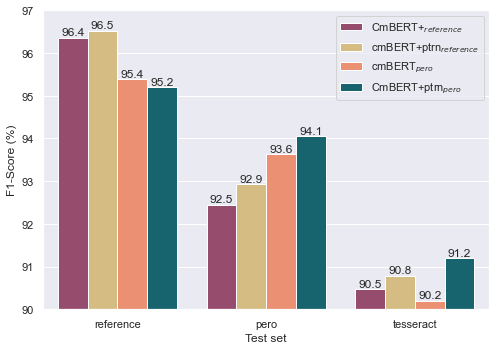

In [ ]:
import seaborn as sns
import matplotlib
sns.set_theme()
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5.5)})

data = reshaped.unstack().reset_index()
data.columns = ["Method", "Test set", "F1-Score (%)"]
ax = sns.barplot(data=data, x="Test set", y = "F1-Score (%)", hue="Method", palette=["#A2416B","#E2C275","#FF865E","#086E7D"])
ax.legend(loc='upper right', title='')
ax.set_ylim(90,97)

assert(matplotlib.__version__ >= "3.4.0")
for container in ax.containers:
    bars = ax.bar_label(container,fmt="%.1f")


matplotlib.pyplot.savefig('experiment_2_f1_with_noise_graph.pdf', dpi=300, format='pdf',bbox_inches='tight')


In [ ]:

print(reshaped.to_latex(float_format="%.1f", multirow=True, caption="",escape = False))

\begin{tabular}{lrrrr}
\toprule
{} &  CmBERT+$_{reference}$ &  cmBERT+ptrn$_{reference}$ &  cmBERT$_{pero}$ &  CmBERT+ptrn$_{pero}$ \\
tested_on &                        &                            &                  &                       \\
\midrule
reference &                   96.4 &                       96.5 &             95.4 &                  95.2 \\
pero      &                   92.5 &                       92.9 &             93.6 &                  94.1 \\
tesseract &                   90.5 &                       90.8 &             90.2 &                  91.2 \\
\bottomrule
\end{tabular}

